# Variational Autoencoders with Gluon

Recent progress in variation autoencoders (VAE) has made it one of the most popular frameworks for building deep generative models. In this notebook, we will first introduce the necessary background. Then, we proceed to build a VAE model based on the paper [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) and apply it to MNIST dataset for representation learning and sample generation tasks. In this implementation we use the MXNet Gluon API, i.e. `gluon.HybridBlock` and `autograd`.


## Introduction of Variational Autoencoders (VAE)

### A Quick Recap of Expectation-Maximization (EM)
A straightforward way to approach VAE is through the construction of the well-known Expectation-Maximization (EM) algorithm. Please refer to this [tutorial](https://www2.ee.washington.edu/techsite/papers/documents/UWEETR-2010-0002.pdf) or this [blog](https://dingran.github.io/algorithm/EM/) as a refresher on EM. Just to quicly recap a few key elements in EM: insteand of optimizing the log-liklihood ($\ell(\theta)$) directly with observable data $x$, latent variable $z$, EM constructs and optimize on a lower bound $\mathcal{L}(q,\theta)$ often referred to as **Evidence Lower Bond (EBLO)**. The following equation derives from Jensen's inequality and holds for any $q(z)$ as long as it is a valid probability distribution.

$$
\begin{equation*}
\begin{split}
\ell(\theta) &= \sum_i \log\left( p_{\theta}(x_i) \right) \\
& = \sum_i \log\left( \int p_{\theta}(x_i, z) dz \right)\\
&= \sum_i \log\left( \mathbb{E}_{z \sim Q} \left[ \frac {p_{\theta}(x_i, z)}{q(z)} \right]\right)\\
& {\ge}\underbrace{ \sum_i \mathbb{E}_{z \sim Q} \left[\log\left( \frac {p_{\theta}(x_i,z)}{q(z)} \right)\right]}_{ELBO: \mathcal{L}(q,\theta)}
\end{split}
\end{equation*}
$$

Importantly, among all choices of $q(z)$, we'd be able to maximize the ELBO $\mathcal{L}(q,\theta)$ with respect to $q$ if $q$ is chosen to be the inferred posterior, i.e. at $t$-th iteration $q^t(z) = p(z\vert x_i; \hat\theta^{t-1}) = \frac{p(x_i\vert z; \hat\theta^{t-1})p(z; \hat\theta^{t-1})}{\int p(x_i\vert z; \hat\theta^{t-1})p(z; \hat\theta^{t-1}) dz}$. This is the essesce of the E-step in EM algorithm. In M-step, we then maximize over $\theta$. The particular choice of $q(z)$ in E-step ensures that EM would monotonically increase the ELBO  $\mathcal{L}(q,\theta)$, thus the log-liklihood $\ell(\theta)$. The chain of improvements through E-step and M-step are illustrated below.

$$\ell(\theta^{t-1}) \underset{E-step}{=} \mathcal L(q^t,\theta^{t-1}) \underset{M-step}{\le} \mathcal L(q^t,\theta^t) \underset{Jensen}{\le} \ell(\theta^{t})$$

### From EM to VAE

With more complex distributions of $p_\theta(x\vert z)$, the integration in E-step for **exact inference** of the posterier $p_\theta(z\vert x)$ is intractable. This posterier inference problem can be addressed with **variational inference** methods such as mean-field approximation (where we assume factorizable $q(z)$) or sampling based methods (e.g. collapsed Gibbs sampling for solving Latent Dirichlet allocation). Mean-field approximation put undue constraints on the variational family $q(z)$, and sampling based methods could have slow convergence problems. Moreover, both methods involves arduous derivation of update functions, that would require rederivation even for small changes in model and thus could limit the exploration of more complex models.

[Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) brought about a flexible neural-network based approach. In this framework, the variational inference / variational optimization task of finding the optimal $q$ become a matter of finding the best parameters of a neural network via backpropagation and stochastic gradient descent. Thus making blackbox inference possible as well as allowing scalable trainng for deeper and larger neural network models. We refer to this framework as **Neural Variational Inference**.

Here is how it works:
- Select a prior for latent variable $p_\theta(z)$, which may or may not actually involve parameters.
- Use a neural network to parameterize the distribution $p_\theta(x\vert z)$. Because this part of the model maps latent varibale (code) $z$ to observed data $x$, it is viewed as a "decoder" network.
- Rather than explictly calculating the intractable $p(z\vert x)$, use another neural network to parameterize the distribution $q_\phi(z\vert x)$ as the approximate posterior. Due to the mapping from from data $x$ to latent variable (code) $z$, this part of the model is viewed as a "encoder" network.
- The objective is still to maxmize ELBO $\mathcal{L}(\phi,\theta)$. But now instead of separately finding the optimal $\phi$ (corresponding to $q$ in EM) and $\theta$ like EM, we can find the parameters $\theta$ and $\phi$ jointly via standard stochastic gradient descent.

The resulted model resembles an encoder-decoder structure, thus commonly referred to as **variational auto-encoder (VAE)**. 

In the classic example in [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114), we have the prior $p(z)$ as a standard isotropic Gaussian $\mathcal N(0, I)$, and the approximate posterior $q_\phi(z\vert x)$ also be isotropic Gaussian $\mathcal N(\mu_\phi(x), \sigma_\phi(x) I)$, where $\mu_\phi(x)$ and $\sigma_\phi(x)$ are functions implemented as neural networks and their outputs are used as the parameters for the Guassian distribution $q_\phi(z\vert x)$. This model configuration is often referred as **Gaussian VAE**.

With this setup the training loss to minimize is the negative of ELBO and can be expressed as follows:

$$
\begin{equation*}
\begin{split}
- \mathcal L(x_i, \phi,\theta) & = - \mathbb{E}_{z \sim Q_\phi(z|x_i)} \left[\log p_{\theta}(x_i \vert z) + \log p_\theta(z) - \log q_\phi(z\vert x_i) \right] \\
& = - \mathbb{E}_{z \sim Q_\phi(z|x_i)} \left[\log p_{\theta}(x_i \vert z) \right] + D_{KL}\left[\log q_\phi(z\vert x_i) \| p_\theta(z)\right] \\
& \approx \underbrace{\frac{1}{L} \sum_s^L \left[-\log p_{\theta}(x_i \vert z_s) \right]}_{\text{Sampling}\  z_s \sim Q_\phi(z\vert x_i)} + \underbrace{D_{KL}\left[\log q_\phi(z\vert x_i) \| p_\theta(z)\right]}_{\text{Can be calculated analytically between Gaussians}}
\end{split}
\end{equation*}
$$

where the ELBO above is the same as the ELBO expression in EM but with $p(x,z)$ expanded and with $D_{KL}$ denoting the KL-divergence, i.e. $D_{KL}(Q \| P)= \mathbb{E}_{x\sim Q}[\log(\frac{q(x)}{p(x)}]$. As indicated, the first term can be approximated by drawing $L$ Monte Carlo samples from the distribution $q_\phi(z\vert x)$ (a very feasible task of drawing from an isotropic Gaussian distribution), while the $D_{KL}$ has convenient analytical solutions which is preferred over Monte Carlo samples in order to have lower variance gradient. 

With sampling involved, the remaining question is how do we backpropagate through a sampling node in the computation graph. The authors of [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) proposed **Reparameterize Trick (RT)**. Instead of sampling $z$ from $\mathcal N(\mu_\phi(x), \sigma_\phi(x) I)$ directly, we sample $\epsilon$ from fixed distribution $\mathcal{N}(0,I)$ and construct $z = \mu(x) + \sigma(x) \cdot \epsilon$. This way the random sampling is based on $\epsilon$, and $z$ deterministically depends on $\mu(x)$ and $\sigma(x)$ allowing gradient to flow through them. RT is a generally applicable technique for distribution that allows location-scale transformation or has analytical inverse CDFs. 

# Implementing a Gaussian VAE

With the theoretical side of things out of the way, let's start implemting a VAE model!

In [1]:
import time
import numpy as np
import mxnet as mx
from tqdm import tqdm, tqdm_notebook
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt
%matplotlib inline

/Users/rding/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/rding/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
def gpu_exists():
    try:
        mx.nd.zeros((1,), ctx=mx.gpu(0))
    except:
        return False
    return True

data_ctx = mx.cpu()
if gpu_exists():
    print('Using GPU for model_ctx')
    model_ctx = mx.gpu(0)
else:
    print('Using CPU for model_ctx')
    model_ctx = mx.cpu()

Using CPU for model_ctx


In [3]:
mx.random.seed(1)
output_fig = False

## Load MNIST

/Users/rding/anaconda3/lib/python3.6/site-packages/mxnet/test_utils.py:1430: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(flbl.read(), dtype=np.int8)
/Users/rding/anaconda3/lib/python3.6/site-packages/mxnet/test_utils.py:1433: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)


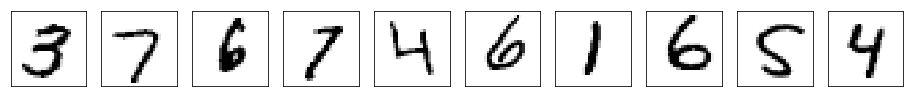

In [4]:
mnist = mx.test_utils.get_mnist()
#print(mnist['train_data'][0].shape)
#plt.imshow(mnist['train_data'][0][0],cmap='Greys')

n_samples = 10
idx = np.random.choice(len(mnist['train_data']), n_samples)
_, axarr = plt.subplots(1, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[i].imshow(mnist['train_data'][j][0], cmap='Greys')
    #axarr[i].axis('off')
    axarr[i].get_xaxis().set_ticks([])
    axarr[i].get_yaxis().set_ticks([])
plt.show()

In [5]:
train_data = np.reshape(mnist['train_data'],(-1,28*28))
test_data = np.reshape(mnist['test_data'],(-1,28*28))

In [6]:
mnist['test_label'].shape

(10000,)

In [7]:
batch_size = 100
n_batches = train_data.shape[0]/batch_size
train_iter = mx.io.NDArrayIter(data={'data': train_data}, label={'label': mnist['train_label']}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': test_data}, label={'label': mnist['test_label']}, batch_size = batch_size)
#train_iter = mx.io.NDArrayIter(data={'data': train_data}, batch_size = batch_size)
#test_iter = mx.io.NDArrayIter(data={'data': test_data}, batch_size = batch_size)

## Define model

In [8]:
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        # note to self: requring batch_size in model definition is sad, not sure how to deal with this otherwise though
        super(VAE, self).__init__(**kwargs)
        # self.use_aux_logits = use_aux_logits
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None)) 
            
            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid')) 

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu
        #eps = F.random_normal(loc=0, scale=1, shape=mu.shape, ctx=model_ctx) 
        # this would work fine only for nd (i.e. non-hybridized block)
        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL
        
        return loss

In [9]:
n_hidden=400
n_latent=2
n_layers=2 # num of dense layers in encoder and decoder respectively
n_output=784
model_prefix = 'vae_gluon_{}d{}l{}h.params'.format(n_latent, n_layers, n_hidden)

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size)

## Model training

In [10]:
net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .001})

In [11]:
n_epoch = 50
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0
    
    train_iter.reset()
    test_iter.reset()
    
    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(model_ctx)
        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()
    
    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(model_ctx)
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()
    
    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val
    
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)
    
    if epoch % max(print_period,1) == 0:
        tqdm.write('Epoch{}, Training loss {:.2f}, Validation loss {:.2f}'.format(epoch, epoch_loss, epoch_val_loss))
        
end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

A Jupyter Widget

Epoch0, Training loss 184.74, Validation loss 171.09
Epoch5, Training loss 149.90, Validation loss 152.18
Epoch10, Training loss 144.68, Validation loss 147.63
Epoch15, Training loss 142.25, Validation loss 145.02
Epoch20, Training loss 140.76, Validation loss 143.81
Epoch25, Training loss 139.74, Validation loss 144.16
Epoch30, Training loss 138.88, Validation loss 142.90
Epoch35, Training loss 138.06, Validation loss 141.46
Epoch40, Training loss 137.90, Validation loss 141.75
Epoch45, Training loss 137.45, Validation loss 141.13

Time elapsed: 1035.14s


In [12]:
net.save_parameters(model_prefix)

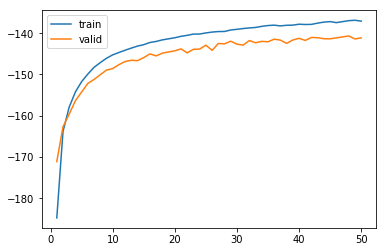

In [13]:
batch_x = np.linspace(1, n_epoch, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])

## Load model

In [14]:
net2 = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size)
net2.load_parameters(model_prefix, ctx=model_ctx)

## Visualizing reconstruction quality

In [15]:
test_iter.reset()
test_batch = test_iter.next()
net2(test_batch.data[0].as_in_context(model_ctx))
result = net2.output.asnumpy()
original = test_batch.data[0].asnumpy()

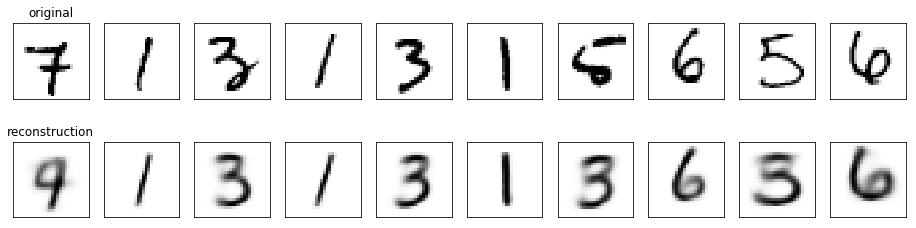

In [16]:
n_samples = 10
idx = np.random.choice(batch_size, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

## Visualizing latent space (when it is 2D)

In [17]:
n_batches = 10
counter = 0
results = []
labels = []
for batch in test_iter:
    net2(batch.data[0].as_in_context(model_ctx))
    results.append(net2.mu.asnumpy())
    labels.append(batch.label[0].asnumpy())
    counter +=1
    if counter >= n_batches:
        break

In [18]:
result= np.vstack(results)
labels = np.hstack(labels)

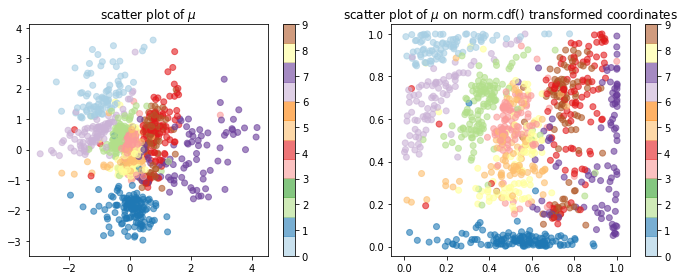

In [24]:
if result.shape[1]==2:
    from scipy.special import ndtri
    from scipy.stats import norm

    fig, axarr = plt.subplots(1,2, figsize=(10,4))
    im=axarr[0].scatter(result[:, 0], result[:, 1], c=labels, alpha=0.6, cmap='Paired')
    axarr[0].set_title(r'scatter plot of $\mu$')
    axarr[0].axis('equal')
    fig.colorbar(im, ax=axarr[0])

    im=axarr[1].scatter(norm.cdf(result[:, 0]), norm.cdf(result[:, 1]), c=labels, alpha=0.6, cmap='Paired')
    axarr[1].set_title(r'scatter plot of $\mu$ on norm.cdf() transformed coordinates')
    axarr[1].axis('equal')
    fig.colorbar(im, ax=axarr[1])
    plt.tight_layout()
    if output_fig:
        plt.savefig('2d_latent_space_for_test_samples.png')

## Sample latent space and generate images

### Random sampling

In [20]:
n_samples = 10
zsamples = nd.array(np.random.randn(n_samples*n_samples, n_latent))

In [21]:
images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

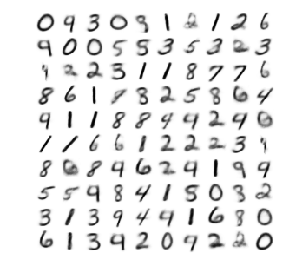

In [22]:
canvas = np.empty((28*n_samples, 28*n_samples))
for i, img in enumerate(images):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*28:(n_samples-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
plt.figure(figsize=(4, 4))        
plt.imshow(canvas, origin="upper", cmap="Greys")
plt.axis('off')
plt.tight_layout()
if output_fig:
    plt.savefig('generated_samples_with_{}D_latent_space.png'.format(n_latent))

### Grid scan 2D latent space

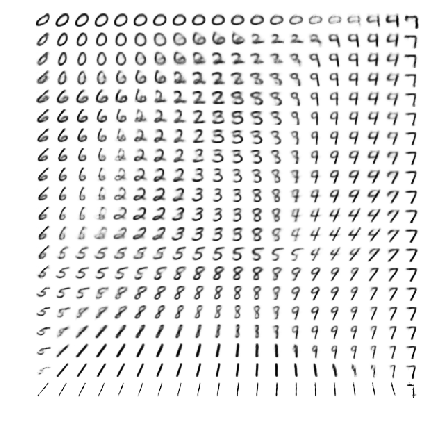

In [23]:
if n_latent==2: 
    n_pts = 20

    idx = np.arange(0, n_pts)

    x = np.linspace(norm.cdf(-3), norm.cdf(3),n_pts)
    x = ndtri(x)

    x_grid = np.array(np.meshgrid(*[i for i in np.matlib.repmat(x,n_latent,1)]))
    id_grid = np.array(np.meshgrid(*[i for i in np.matlib.repmat(idx,n_latent,1)]))

    zsamples = nd.array(x_grid.reshape((n_latent, -1)).transpose())
    zsamples_id = id_grid.reshape((n_latent, -1)).transpose()

    images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

    #plot
    canvas = np.empty((28*n_pts, 28*n_pts))
    for i, img in enumerate(images):
        x, y = zsamples_id[i]
        canvas[(n_pts-y-1)*28:(n_pts-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
    plt.figure(figsize=(6, 6))        
    plt.imshow(canvas, origin="upper", cmap="Greys")
    plt.axis('off')
    plt.tight_layout()
    if output_fig:
        plt.savefig('2d_latent_space_scan_for_generation.png')